# Multi-Label Conditional Diffusion for Disease-Specific Chest X-ray Synthesis using ChestX-ray14

## Import the Required Libraries

In [1]:
import os
import math
import random
import pathlib
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

# For reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

In [2]:
# # Authenticate
# api = KaggleApi()
# api.authenticate()

In [3]:
# Make base directories
base = pathlib.Path("./data")

In [4]:
# # Download & unzip into train folders
# api.dataset_download_files(
#     "nih-chest-xrays/data",
#     path = str(base / 'train'),
#     unzip = False
# )

In [5]:
DISEASES = ['Atelectasis','Cardiomegaly','Effusion','Infiltration',
            'Mass','Nodule','Pneumonia','Pneumothorax',
            'Consolidation','Edema','Emphysema','Fibrosis',
            'Pleural_Thickening','Hernia']

def encode_labels(disease):
    onehot=[0]*14

    for i, d in enumerate(DISEASES):
        if d in str(disease).split("|"):
            onehot[i] = 1
    
    return onehot

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))        
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))        
])

In [7]:
class XRayDataset(Dataset):
    def __init__(self, transform, root_img_dir, csv_path):
        self.df = pd.read_csv(csv_path)
        self.root = pathlib.Path(root_img_dir)
        self.transform = transform 
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.root / row['Image Index']
        img = Image.open(img_path).convert('L')

        if self.transform: 
            img = self.transform(img)

        onehot = torch.tensor(encode_labels(row['Finding Labels']),
                              dtype=torch.float)

        return img, onehot

In [8]:
img_dir = pathlib.Path(r"/workspaces/Multi-Label-Conditional-Diffusion-for-Disease-Specific-Chest-X-ray-Synthesis-using-ChestX-ray14/data")
img_file_paths = list(img_dir.glob("*.png"))
available_imgs = set()   # For fast look-up, and to ensure no duplicates

for img_path in img_file_paths:
    filename = img_path.name
    available_imgs.add(filename)

df = pd.read_csv(r"/workspaces/Multi-Label-Conditional-Diffusion-for-Disease-Specific-Chest-X-ray-Synthesis-using-ChestX-ray14/Data_Entry_2017.csv")

# Filter only rows where image is present in your folder
df_filtered = df[df["Image Index"].isin(available_imgs)]

# Save the filtered CSV
df_filtered.to_csv(r"/workspaces/Multi-Label-Conditional-Diffusion-for-Disease-Specific-Chest-X-ray-Synthesis-using-ChestX-ray14/sample_metadata.csv", index=False)

In [9]:
bs = 32
csv_path = r"/workspaces/Multi-Label-Conditional-Diffusion-for-Disease-Specific-Chest-X-ray-Synthesis-using-ChestX-ray14/sample_metadata.csv"
root_dir = r"/workspaces/Multi-Label-Conditional-Diffusion-for-Disease-Specific-Chest-X-ray-Synthesis-using-ChestX-ray14/data"

train_ds = XRayDataset(train_transform, root_dir, csv_path)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True,  num_workers=0)

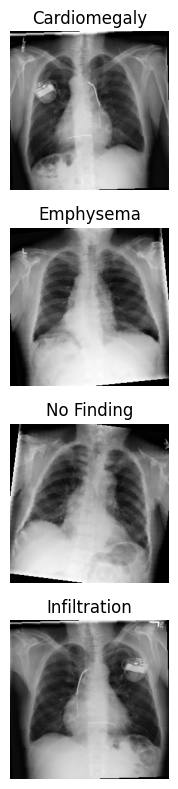

In [10]:
imgs, labels = next(iter(train_dl))
imgs_vis = imgs[:4]*0.5+0.5

fig, axes = plt.subplots(4,1,figsize=(4,8))
for i in range(4):
    axes[i].imshow(imgs_vis[i].permute(1,2,0), cmap='gray')
    title = ' '.join([d for d,flag in zip(DISEASES, labels[i]) if flag==1])
    axes[i].set_title(title if title else 'No Finding')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Diffusion Model

In [11]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_timesteps = 1000):
        super().__init__()

        self.num_timesteps=num_timesteps
        
        # Linear beta schedule from 1e-4 to 0.02
        beta = torch.linspace(1e-4, 0.02, num_timesteps)
        self.register_buffer("beta", beta)

        alpha = 1.0 - beta
        self.register_buffer("alpha", alpha)

        # Cumulative product: alpha_hat_t = prod(alpha_1 to alpha_t)
        alpha_hat = torch.cumprod(alpha, dim=0)
        self.register_buffer("alpha_hat", alpha_hat)

    def get_params(self, t):
        beta_t = self.beta[t].view(-1, 1, 1, 1)
        alpha_t = self.alpha[t].view(-1, 1, 1, 1)
        alpha_hat_t = self.alpha_hat[t].view(-1, 1, 1, 1)
        return beta_t, alpha_t, alpha_hat_t 

### Forward Function for Diffusion Model

In [12]:
def diffusion_forward(x0, t, e, scheduler: DDPM_Scheduler):
    beta_t, alpha_t, alpha_hat_t = scheduler.get_params(t)

    return ((torch.sqrt(alpha_hat_t) * x0) + (torch.sqrt(1 - alpha_hat_t) * e))

### Reverse Function for Diffusion Model (UNet Architecture)

In [13]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.exp(-math.log(10000) * torch.arange(0, half_dim, device=device) / half_dim) 
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)  
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

        if self.dim % 2:
            emb = F.pad(emb, (0, 1))
            
        return emb  # [B, dim]

In [14]:
class LabelEmbedding(nn.Module):
    def __init__(self, num_labels, emb_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_labels, emb_dim),
            nn.ReLU(inplace=True),
            nn.Linear(emb_dim, emb_dim)
        )

    def forward(self, y):
        return self.mlp(y)

In [15]:
class ConditionalGroupNorm(nn.Module):
    def __init__(self, num_features, emb_dim, num_groups=8):
        super().__init__()
        self.gn = nn.GroupNorm(num_groups, num_features, affine=False)
        self.embed = nn.Linear(emb_dim, num_features * 2)

    def forward(self, x, emb):
        B, C, H, W = x.shape
        gamma, beta = self.embed(emb).chunk(2, dim=1)
        gamma = gamma.view(B, C, 1, 1)
        beta = beta.view(B, C, 1, 1)
        x = self.gn(x)
        return x * (1 + gamma) + beta

In [16]:
class DownBlock(nn.Module):
    def __init__(self, in_c, out_c, emb_dim):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1)
        self.norm = ConditionalGroupNorm(out_c, emb_dim)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x, emb):
        x = self.conv(x)
        x = self.norm(x, emb)
        return self.act(x)

In [17]:
class UpBlock(nn.Module):
    def __init__(self, in_c, out_c, emb_dim):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1)
        self.norm = ConditionalGroupNorm(out_c, emb_dim)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x, emb):
        x = self.deconv(x)
        x = self.norm(x, emb)
        return self.act(x)

In [18]:
class UNet(nn.Module):
    def __init__(self,
                 in_channels=1,
                 out_channels=1,
                 features=64,
                 time_emb_dim=256,
                 label_emb_dim=256,
                 num_labels=14):

        super().__init__()

        # Embeddings
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(inplace=True),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.label_mlp = LabelEmbedding(num_labels, label_emb_dim)
        emb_dim = time_emb_dim  

        # Encoder
        self.down1 = DownBlock(in_channels, features, emb_dim)
        self.down2 = DownBlock(features, features * 2, emb_dim)
        self.down3 = DownBlock(features * 2, features * 4, emb_dim)
        self.down4 = DownBlock(features * 4, features * 8, emb_dim)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.up1 = UpBlock(features * 8, features * 8, emb_dim)
        self.up2 = UpBlock(features * 8 * 2, features * 4, emb_dim)
        self.up3 = UpBlock(features * 4 * 2, features * 2, emb_dim)
        self.up4 = UpBlock(features * 2 * 2, features, emb_dim)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(features * 2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x, t, y):
        t_emb = self.time_mlp(t)
        y_emb = self.label_mlp(y)
        emb = t_emb + y_emb  # [B, emb_dim]

        # Encoder
        e1 = self.down1(x, emb)
        e2 = self.down2(e1, emb)
        e3 = self.down3(e2, emb)
        e4 = self.down4(e3, emb)

        # Bottleneck
        b = self.bottleneck(e4)

        # Decoder with skip connections
        d1 = self.up1(b, emb)
        d2 = self.up2(torch.cat([d1, e4], dim=1), emb)
        d3 = self.up3(torch.cat([d2, e3], dim=1), emb)
        d4 = self.up4(torch.cat([d3, e2], dim=1), emb)

        return self.final(torch.cat([d4, e1], dim=1))

In [19]:
def diffusion_reverse(x_T, t, y, noise, model, scheduler):
    beta_t, alpha_t, alpha_hat_t = scheduler.get_params(t)
    eps_pred = model(x_T, t, y)
    coeff1 = 1.0 / torch.sqrt(alpha_t)
    coeff2 = (1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)
    sigma = torch.sqrt(beta_t)

    mask = (t > 0).view(-1,1,1,1).float()

    if (t > 1).all(0):
        return (((coeff1 * x_T) - (coeff1 * coeff2 * eps_pred)) + (sigma * noise * mask))

In [20]:
def sample(model, scheduler, labels, device):
    model.eval()
    B = labels.size(0)
    
    # start from pure noise
    x = torch.randn(B, 1, 256, 256, device=device)

    # iterate t = T-1 ... 0
    for i in reversed(range(scheduler.num_timesteps)):
        t = torch.full((B,), i, dtype=torch.long, device=device)
        x = diffusion_reverse(x, t, labels, model, scheduler)

    # clamp to valid range
    return x.clamp(-1, 1)

### Save Generated Samples

In [21]:
def save_generated_samples(
    epoch_idx: int,
    fixed_labels: torch.Tensor,      
    model: nn.Module,
    scheduler: DDPM_Scheduler,
    denorm_fn,                     
    out_dir: str = "generated",
    show: bool = False,
    device: torch.device = None
):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    device = device or next(model.parameters()).device

    # Sample N images
    with torch.no_grad():
        samples = sample(model, scheduler, fixed_labels.to(device), device)

    samples = denorm_fn(samples) 

    # Save a single grid
    grid = make_grid(samples, nrow=8)
    grid_fname = f"diffusion_epoch_{epoch_idx:04d}.png"
    save_image(grid, os.path.join(out_dir, grid_fname))
    print(f"[Epoch {epoch_idx}] Saved grid → {grid_fname}")

    # Save each image + build label table
    records = []
    for i, (img, label_vec) in enumerate(zip(samples, fixed_labels)):
        fn = f"epoch{epoch_idx:04d}_sample{i:02d}.png"
        save_image(img, os.path.join(out_dir, fn))

        # turn one‐hot into "Atelectasis|Pneumonia", or "NoFinding"
        names = [DISEASES[j] for j,v in enumerate(label_vec) if v==1]
        records.append({
            "filename": fn,
            "labels": "|".join(names) if names else "NoFinding"
        })

    # Write CSV
    df = pd.DataFrame(records)
    csv_name = f"labels_epoch_{epoch_idx:04d}.csv"
    df.to_csv(os.path.join(out_dir, csv_name), index=False)
    print(f"[Epoch {epoch_idx}] Saved labels → {csv_name}")

    # display
    if show:
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.imshow(grid.permute(1,2,0))
        plt.show()

## Training Block

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
# Denormalize from [-1,1] back to [0,1]
def denorm(imgs):
    return imgs * 0.5 + 0.5

In [ ]:
def fit(model: nn.Module,
        scheduler: DDPM_Scheduler,
        train_dl: DataLoader, 
        fixed_labels: torch.Tensor,
        epochs: int, 
        lr: float = 1e-4,
        device = None
        ):

        model.to(device)
        scheduler.to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        for epoch in range(epochs):
                for imgs, labels in tqdm(train_dl, desc=f"Epoch {epoch}/{epochs-1}"):
                        imgs   = imgs.to(device)
                        labels = labels.to(device)
                        B = imgs.size(0)

                        # sample random timesteps and noise
                        t = torch.randint(0, scheduler.num_timesteps, (B,), device=device)
                        noise = torch.randn_like(imgs)

                        # forward diffuse
                        x_t = diffusion_forward(imgs, t, noise, scheduler)

                        # predict noise
                        noise_pred = model(x_t, t, labels)

                        # MSE loss
                        loss = F.mse_loss(noise_pred, noise)

                        # step
                        opt.zero_grad()
                        loss.backward()
                        opt.step()

        # Save generated images
        save_generated_samples(
                epoch_idx=epoch,
                fixed_labels=fixed_labels,
                model=model,
                scheduler=scheduler,
                denorm_fn=denorm,
                out_dir="generated",
                show=False,
                device=device
                )

        return model

In [25]:
model     = UNet().to(device)
scheduler = DDPM_Scheduler().to(device)

# Grab a fixed batch of labels for monitoring samples
fixed_imgs, fixed_labels = next(iter(train_dl))
fixed_labels = fixed_labels.to(device)

# Run training
history = fit(
    model,           
    scheduler,      
    train_dl,      
    fixed_labels=fixed_labels, 
    epochs   = 100, 
    lr       = 2e-4,
    device   = device
)

Epoch 99/99: 100%|██████████| 3/3 [00:49<00:00, 16.39s/it]


TypeError: diffusion_reverse() missing 1 required positional argument: 'scheduler'